In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import math
from itertools import islice
import sys
import operator
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib
import os

# Column formats
headers = ["Year", "Month", "Day", "Hour", "Minute",
           "Power"]

data_i = pd.read_csv("SpatialCorrelationData/FirstFarm/9074-2012.csv", sep=',', skiprows=4, names=headers)
# print(data.head)

headers_err = ["Year", "Month", "Day", "Hour", "Minute",
           "Power", "Air Temperature"]
data_ii = pd.read_csv("SpatialCorrelationData/SecondFarm/9073-2012.csv", sep=',', skiprows=4, names=headers_err)



### Resolution definition

In [9]:
req_resolution = 1 # in (MW)

max_wind_power = data_i['Power'].max()
min_wind_power = data_i['Power'].min()

# Discretise wind power
n_bins = int(math.ceil((max_wind_power - min_wind_power) / req_resolution))

order = 2
# Construct transition matrix
kernel_mtx = [[0.0 for i in range(n_bins ** order)] for j in range(n_bins ** order)]

bin_size = (max_wind_power - min_wind_power) / n_bins

In [10]:

directory_i = "SpatialCorrelationData/FirstFarm/"
directory_ii = "SpatialCorrelationData/SecondFarm/"

data_set_cnt = 0
for filename in os.listdir(directory_i):
    data_set_cnt += 1
    print("Training Set: ", data_set_cnt)
    temp = filename.split('-')
    data_i = pd.read_csv("SpatialCorrelationData/FirstFarm/%s" % filename, sep=',', skiprows=4, names=headers)
    temp_filename = "9073-" + temp[1]
    data_ii = pd.read_csv("SpatialCorrelationData/SecondFarm/%s" % temp_filename, sep=',', skiprows=4, names=headers_err)
    
    prev_state_idx_i, prev_state_idx_ii = [None for _ in range(order)], [None for _ in range(order)]

    for i in range(0, order):
        power_state_i = data_i['Power'][i]
        power_state_ii = data_ii['Power'][i]

        prev_state_idx_i[i] = int(power_state_i / bin_size)
        prev_state_idx_ii[i] = int(power_state_ii / bin_size)

    curr_state_idx_i, curr_state_idx_ii = [None for _ in range(order)], [None for _ in range(order)] 

    for i in range(order, len(data_i) - 1):    

        curr_state_idx_i[0] = int(data_i['Power'][i] / bin_size)
        curr_state_idx_ii[0] = int(data_ii['Power'][i] / bin_size)

        # Calculate previous index
        temp_prev = prev_state_idx_i[0] * (n_bins - 1) + prev_state_idx_ii[0] - 1
        
        # Calculate current index
        temp_curr = curr_state_idx_i[0] * (n_bins - 1) + curr_state_idx_ii[0] - 1
        
        kernel_mtx[temp_prev][temp_curr] += 1

        # Update previous index
        prev_state_idx_i[0] = curr_state_idx_i[0]
        prev_state_idx_ii[1] = curr_state_idx_i[0]

# Normalise
for j in range(len(kernel_mtx)):
            norm_sum = 0
            for elem in kernel_mtx[j]:
                norm_sum += elem
            if norm_sum != 0:    
                kernel_mtx[j] = [x / norm_sum for x in kernel_mtx[j]] 

Training Set:  1
Training Set:  2
Training Set:  3
Training Set:  4
Training Set:  5
Training Set:  6


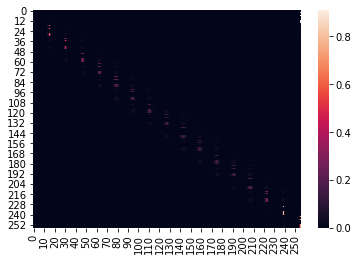

In [11]:
ax = seaborn.heatmap(kernel_mtx)

In [21]:
def normalize(v):
    temp_sum = numpy.sum(v)
    # norm = np.linalg.norm(v)
    if temp == 0: 
        return v
    return np.true_divide(v, temp_sum)

In [22]:
import numpy
from random import choices

# Initialise start state
curr_state_vec = [0.0 for i in range(n_bins**order)]

# Choose year = 2012
data_i = pd.read_csv("SpatialCorrelationData/FirstFarm/9074-2012.csv", sep=',', skiprows=4, names=headers)
data_ii = pd.read_csv("SpatialCorrelationData/SecondFarm/9073-2012.csv", sep=',', skiprows=4, names=headers_err)

print("No. of bins: ", n_bins, bin_size)
curr_state_idx = int(data_i['Power'][0] / bin_size) * (n_bins - 1) + int(data_ii['Power'][0] / bin_size) - 1
print(data_i['Power'][0], data_ii['Power'][0])
curr_state_vec[curr_state_idx] = 1

print("Start vector initialisation complete")

# Numpy conversion
curr_state_vec_np    = np.array(curr_state_vec)
transition_kernel_np = np.array(kernel_mtx)

print("Numpy conversions done")

future_time = 180 # min
num_steps = int(future_time / 5)

for i in range(num_steps):
    
    # Generate prediction
    future_state_vec_np = curr_state_vec_np.dot(transition_kernel_np)
    
    #Normalize
    future_state_vec_np = normalize(future_state_vec_np)
    print(numpy.sum(future_state_vec_np))
    
    
    # Distribution sampling
    sample_idx = choices(numpy.arange(0, len(future_state_vec_np)), future_state_vec_np)
#     sample_idx = numpy.random.choice(numpy.arange(0, len(future_state_vec_np)), p=future_state_vec_np)
    
    power_state_a = int(sample_idx[0] / 16)
    power_state_b = sample_idx[0] % 16
    
    print(power_state_a, power_state_b)
    curr_state_vec_np = future_state_vec_np

print("Prediction complete")





No. of bins:  16 1.0
16.0 16.0
Start vector initialisation complete
Numpy conversions done
1.0
15 15
1.0
15 15
1.0
15 15
1.0
15 15
1.0
15 15
1.0
15 14
1.0
14 13
1.0
15 15
1.0
12 15
1.0
15 15
1.0
15 14
1.0
15 15
1.0
13 1
1.0
15 15
1.0
15 14
1.0
14 15
1.0
14 15
1.0
14 15
1.0
15 15
1.0
15 14
1.0
14 15
1.0
14 15
1.0
14 15
1.0
14 15
1.0
15 15
1.0
14 15
1.0
13 15
1.0
15 14
1.0
13 15
1.0
15 15
1.0
15 15
1.0
14 15
1.0
15 15
1.0
14 15
1.0
13 15
1.0
14 15
Prediction complete
